In [1]:
from collections import Counter
import matplotlib.pyplot as plt
import os
import pandas as pd
import re

import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.probability import FreqDist
nltk.download ('stopwords')
nltk.download ('punkt')

[nltk_data] Downloading package stopwords to /home/titian/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /home/titian/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

## Data Import & Cleaning

Load files, remove unneccessary information and prepare for analysis.

In [2]:
# directory specifications
subtitle_dir = "subtitles"
seasons = ["S01", "S02", "S03", "S04"]

# store imported file content
columns = ('season', 'episode', 'title', 'subtitles')
df = pd.DataFrame(columns=columns)

# loop through all season folders
for s in seasons:
    directory = os.getcwd() + "/subtitles" + "/" + s
    
    # loop through files if directory exists
    try:
        for f in os.listdir(directory):
            if f.endswith(".srt"):
                file_path = os.path.join(directory, f)
                file = open(file_path, mode='r', encoding='utf-8-sig')
                file_content = file.read().splitlines()
                
                df = df.append({'season': int(s[-2:]), 
                                'episode': int(f[4:6]),
                                'title': f[7:-4],
                                'subtitles': file_content}, ignore_index=True)

    # directory does not exist
    except FileNotFoundError:
        print("Directory " + subtitle_dir + "/" + s + " not found.")

Directory subtitles/S02 not found.
Directory subtitles/S03 not found.
Directory subtitles/S04 not found.


In [3]:
def clean_subtitles(subtitles):
    """
    Cleans list of strings imported from .srt file.
    
    Removes:
    - numbering
    - timestamps
    - empty strings
    - contractions
    - specicial characters
    - upper case leters
    
    Returns: List of remaining strings.
    """
    # remove numbering, empty strings & timestamps
    subtitles = [l for l in subtitles if (not l.isdigit() and l != '' and '-->' not in l)]
    
    # replace contractions
    subtitles = [l.replace("'m", " am")
                  .replace("can't", "cannot") 
                  .replace("n't", " not")
                  .replace("'ve", " have")
                  .replace("'re", " are")
                  .replace("'ll", " will")
                  .replace("'d", " would")
                  .replace("'s", "") # could be "is" or posessive
                 for l in subtitles]
    
    # remove special characters
    subtitles = [re.sub("[^a-zA-Z0-9 ]", "" , l) for l in subtitles]
    
    # convert everything to lowercase
    subtitles = [l.lower() for l in subtitles]
    
    return subtitles

# apply cleaning function to df
df['subtitles'] = df['subtitles'].apply(clean_subtitles)

# order df by season and episode
df = df.sort_values(by=['season', 'episode'])
df = df.reset_index(drop=True)

df.head(10)

,season,episode,title,subtitles
0,1,1,eps1.0_hellofriend.mov,"[hello friend, hello friend, that lame, maybe ..."
1,1,2,eps1.1_ones-and-zer0es.mpeg,"[what i am about to tell you is top secret, ev..."
2,1,3,eps1.2_d3bug.mkv,"[i will be the youngest executive, this compan..."
3,1,4,eps1.3_da3m0ns.mp4,"[steel mountain the hacker dilemma, what to do..."
4,1,5,eps1.4_3xpl0its.wmv,[he wants to hack steel mountain climate contr...
5,1,6,eps1.5_br4ve-trave1er.asf,"[did you have something, to do with vera getti..."
6,1,7,eps1.6_v1ew-s0urce.flv,"[so what do we got, terry colby was involved i..."
7,1,8,eps1.7_wh1ter0se.m4v,"[the redundant backups at their, eastern data ..."
8,1,9,eps1.8_m1rr0r1ng.qt,"[exciting time in the world right now, exciti..."
9,1,10,eps1.9_zer0-day.avi,"[come on will you will, you go come on go go, ..."


## Text Exploration & Analytics

- Word Frequency: number of words per song
- Word Length: average length of individual words in a text
- Lexical Diversity: number of unique words used in a text (song vocabulary)
- Lexical Density: the number of unique words divided by the total number of words (word repetition)

- Episodes With Highest Word Count
- Episode Word Count Distribution
- Word count vs. episode length?
- Most frequently used words per episode/season

- Word length distribution
- Word cloud with longest words?

- Lexical diversity over episodes
- Lexical density over episodes
- Lexical div./dens. vs. rating (maybe vs. episode length?)


### Open Ideas:
- TF-IDF??!! (allows to keep stop words)
- Remove stop words?!
- Stemming?!

Identify undesirable words that should be removed.

In [7]:
# tokenize subtitles into words
df['word_tokens'] = df['subtitles'].apply(lambda x: word_tokenize(" ".join(x)))

# remove stop words
stop_words = set(stopwords.words("english"))
df['word_tokens_clean'] = df['word_tokens'].apply(lambda x: [w for w in x if w not in stop_words])

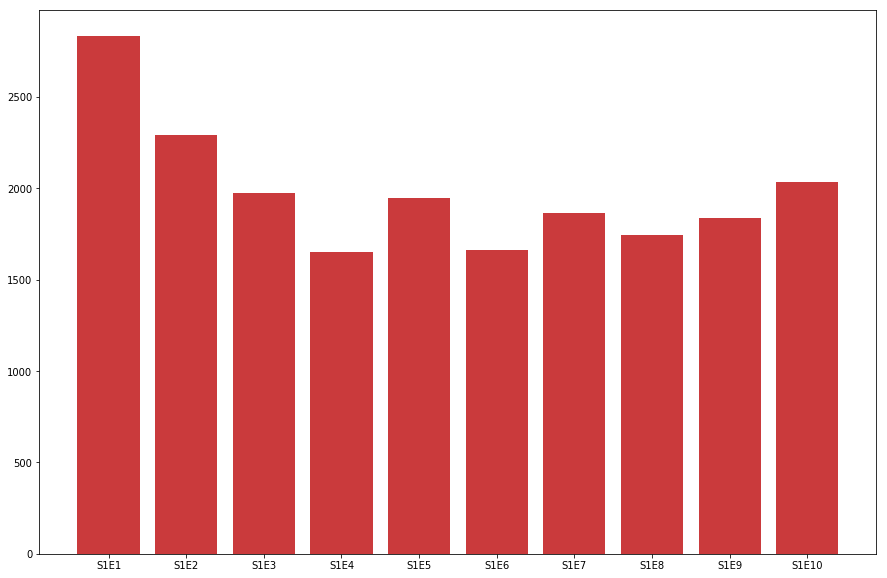

In [40]:
# number of words per episode
fig, ax = plt.subplots(1, 1, figsize=(15, 10))

episodes = df['word_tokens_clean'].index
seasons = df['season']
word_counts = df['word_tokens_clean'].str.len()
tick_labels = ["S" + str(x) + "E" + str(y) for x, y in zip(df['season'], df['episode'])]
colors = ['#CA3A3C' if s == 1 
          else '#F47B3D' if s == 2 
          else '#61A783' if s == 3
          else '#41A2AE' if s == 4
          else '' for s in seasons]

ax.bar(episodes, word_counts, color=colors)
ax.set_xticks(episodes)
ax.set_xticklabels(tick_labels)

plt.show()

## add episode length as line for comparison

In [ ]:
# plot frequency distributions for cleaned word lists
fig, axs = plt.subplots(2, 5, figsize=(15,10))
axs = [ax for sublist in axs for ax in sublist]

for i, (ix, row) in enumerate(df.iterrows()):
    counts = Counter(row['word_tokens_clean']).most_common(10)
    axs[i].plot([x[0] for x in counts], [x[1] for x in counts])

plt.show()

,season,episode,title,subtitles,word_tokens,word_tokens_clean
0,1,1,eps1.0_hellofriend.mov,"[hello friend, hello friend, that lame, maybe ...","[hello, friend, hello, friend, that, lame, may...","[hello, friend, hello, friend, lame, maybe, gi..."
1,1,2,eps1.1_ones-and-zer0es.mpeg,"[what i am about to tell you is top secret, ev...","[what, i, am, about, to, tell, you, is, top, s...","[tell, top, secret, evil, corp, tyrell, wellic..."
2,1,3,eps1.2_d3bug.mkv,"[i will be the youngest executive, this compan...","[i, will, be, the, youngest, executive, this, ...","[youngest, executive, company, ever, seen, rig..."
3,1,4,eps1.3_da3m0ns.mp4,"[steel mountain the hacker dilemma, what to do...","[steel, mountain, the, hacker, dilemma, what, ...","[steel, mountain, hacker, dilemma, bunch, data..."
4,1,5,eps1.4_3xpl0its.wmv,[he wants to hack steel mountain climate contr...,"[he, wants, to, hack, steel, mountain, climate...","[wants, hack, steel, mountain, climate, contro..."


ValueError: setting an array element with a sequence.

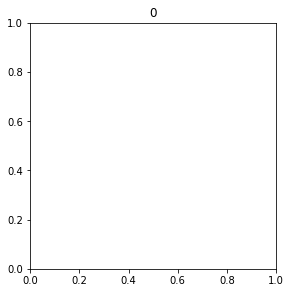